In [2]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models
import var, fcts

from project import files, defs, col
from lib import data, plot as lp, bdt as lBDT
from project.defs import list_samples_columns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S},
    "N": {"N": N, "std_N": std_N},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)


In [5]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)


In [6]:
dataframe_mixed = dataframe[list_samples_columns]

In [22]:
kmeans = KMeans(
    init="k-means++",
    n_clusters=3, random_state=rng.integers(2**32)
)
kmeans = kmeans.fit(dataframe_mixed)

In [23]:
dataframe_mixed["kmeans"] = kmeans.labels_

In [24]:
def get_edges_from_cats(cats):
    cats = np.unique(cats)
    mini = min(cats)
    maxi = max(cats)
    nb = len(cats)
    return np.linspace(mini - 0.5, maxi + 0.5, nb+1, endpoint=True)

In [25]:
dataframe_mixed['is_sig'] = dataframe['is_sig']
dataframe_mixed['is_peaked'] = dataframe['is_peaked']
dataframe_mixed['is_noise'] = dataframe['is_noise']

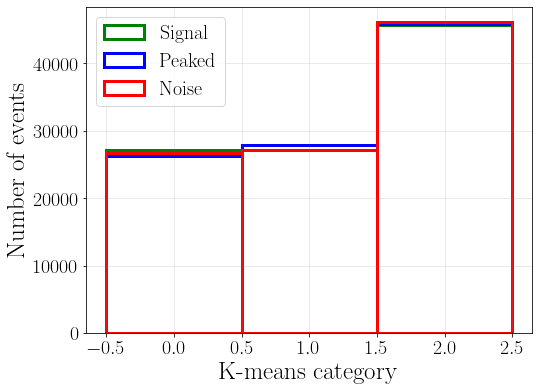

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
cats = ["S", "P", "N"]

edges = get_edges_from_cats(dataframe_mixed["kmeans"])
for cat in cats:
    dataframe_mixed_cat = dataframe_mixed.query(
        f"{models.dict_df_flags[cat]}==True"
    )
    lp.plot_hist(
        dataframe_mixed_cat["kmeans"],
        "K-means category",
        label=var.dict_df_labels[cat],
        fc=(0, 0, 0, 0),
        edgecolor=var.dict_df_colors[cat],
        ax=ax,
        bins=edges,
        lw=3
    )

ax.legend()

In [33]:
labels = dataframe_mixed["is_sig"] * 1 + dataframe_mixed["is_noise"] * 2 + dataframe_mixed["is_peaked"] * 3

In [40]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [41]:
df = dataframe_mixed

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init = "k-means++", n_clusters = 3, n_init = 4, random_state = rng.integers(2**32))
bench_k_means(kmeans=kmeans, name="k-means++", data=df, labels=labels)

kmeans = KMeans(init = "random", n_clusters = 3, n_init = 4, random_state = rng.integers(2**32))
bench_k_means(kmeans=kmeans, name="random", data=df, labels=labels)

pca = PCA(n_components = 3).fit(df)
kmeans = KMeans(init = pca.components_, n_clusters = 3, n_init = 1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=df, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	5.401s	2734031	0.000	0.000	0.000	0.000	0.000	0.525
random   	4.354s	2734031	0.000	0.000	0.000	0.000	0.000	0.486
PCA-based	3.758s	4433340	0.294	0.318	0.305	0.164	0.305	0.283
__________________________________________________________________________________


In [42]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=20, min_samples=50)
db = db.fit(dataframe_mixed)
dataframe_mixed['db'] = db.labels_

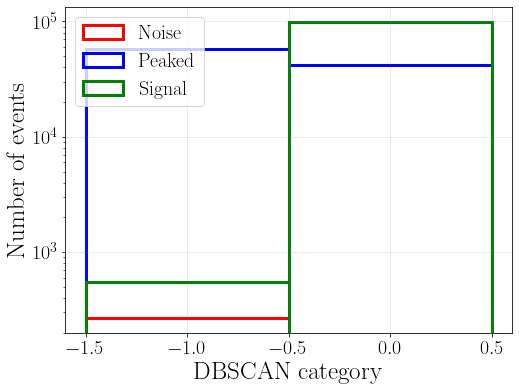

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
edges = get_edges_from_cats(dataframe_mixed["db"])

for cat in cats[::-1]:
    dataframe_mixed_cat = dataframe_mixed.query(
        f"{models.dict_df_flags[cat]}==True"
    )
    lp.plot_hist(
        dataframe_mixed_cat["db"],
        "DBSCAN category",
        label=var.dict_df_labels[cat],
        edgecolor=var.dict_df_colors[cat],
        ax=ax,
        bins=edges,
        lw=3,
        fc=[0, 0, 0, 0],
        #alpha=1,
        logscale=True
    )

ax.legend()